<a href="https://colab.research.google.com/github/justjstine/KitaKo-model/blob/main/Train_YOLO_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.&nbsp;Gather and Label Training Images

Before we start training, we need to gather and label images that will be used for training the object detection model. A good starting point for a proof-of-concept model is 200 images. The training images should have random objects in the image along with the desired objects, and should have a variety of backgrounds and lighting conditions.

There are a couple options for gathering images:


*   Build a custom dataset by taking your own pictures of the objects and labeling them (this typically results in the best performance)
*   Find a pre-made dataset from sources like [Roboflow Universe](), [Kaggle](), or [Google Images V7]()


If you want to build your own dataset, there are several tools available for labeling images. One good option is [Label Studio](https://labelstud.io/?utm_source=youtube&utm_medium=video&utm_campaign=edjeelectronics), a free and open-source labeling tool that has a simple workflow while providing capabilities for more advanced features. My YouTube video that walks through this notebook (link to be added soon) shows how to label images with Label Studio.

If you used Label Studio to label and export the images, they'll be exported in a `project.zip` file that contains the following:

- An `images` folder containing the images
- A `labels` folder containing the labels in YOLO annotation format
- A `classes.txt` labelmap file that contains all the classes
- A `notes.json` file that contains info specific to Label Studio (this file can be ignored)

If you obtained your dataset from another source (like Roboflow Universe) or used another tool to label your dataset, make sure the files are organized in the same folder structure.


Once you've got your dataset built, put into the file structure shown above, and zipped into `data.zip`, you're ready to move on to the next step.

# 2.&nbsp;Upload Image Dataset and Prepare Training Data

Next, we'll upload our dataset and prepare it for training with YOLO. We'll split the dataset into train and validation folders, and we'll automatically generate the configuration file for training the model.

## 2.1 Upload images

First, we need to upload the dataset to Colab. Here are a few options for moving the `data.zip` folder into this Colab instance.

**Option 1. Upload through Google Colab**

Upload the `data.zip` file to the Google Colab instance by clicking the "Files" icon on the left hand side of the browser, and then the "Upload to session storage" icon. Select the zip folder to upload it.

<p>
<br>
<img src="https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/doc/upload-colab-files.png" height="240">
</p>


## 2.2 Split images into train and validation folders

In [1]:
# Unzip images to a custom data folder. This needs to be executed before splitting.
!unzip -q /content/data.zip -d /content/custom_data

Ultralytics requires a particular folder structure to store training data for models. Ultralytics requires a particular folder structure to store training data for models. The root folder is named “data”. Inside, there are two main folders:

*   **Train**: These are the actual images used to train the model. In one epoch of training, every image in the train set is passed into the neural network. The training algorithm adjusts the network weights to fit the data in the images.


*   **Validation**: These images are used to check the model's performance at the end of each training epoch.

In each of these folders is a “images” folder and a “labels” folder, which hold the image files and annotation files respectively.

In [3]:
import os
import random
import shutil

def create_data_split(datapath, train_pct, val_pct, test_pct):
    # Ensure percentages sum to 1 or close to it
    if not (0.99 <= (train_pct + val_pct + test_pct) <= 1.01):
        print("Warning: train_pct, val_pct, and test_pct do not sum to 1.")

    # Define base output directory
    output_base_path = '/content/data'
    if os.path.exists(output_base_path):
        print(f"Removing existing data directory at {output_base_path}")
        shutil.rmtree(output_base_path)

    # Create main data directories
    train_dir = os.path.join(output_base_path, 'train')
    val_dir = os.path.join(output_base_path, 'validation')
    test_dir = os.path.join(output_base_path, 'test')

    for d in [train_dir, val_dir, test_dir]:
        os.makedirs(os.path.join(d, 'images'), exist_ok=True)
        os.makedirs(os.path.join(d, 'labels'), exist_ok=True)

    print(f"Created folders at {train_dir}, {val_dir}, {test_dir}.")

    # Get all image and label files
    image_files = [f for f in os.listdir(os.path.join(datapath, 'images')) if f.endswith(('.jpg', '.jpeg', '.png'))]
    label_files = [f for f in os.listdir(os.path.join(datapath, 'labels')) if f.endswith('.txt')]

    # Filter to ensure matching image and label pairs
    base_names = {os.path.splitext(f)[0] for f in image_files}
    filtered_image_files = [f for f in image_files if os.path.splitext(f)[0] in base_names]
    filtered_label_files = [f for f in label_files if os.path.splitext(f)[0] in base_names]

    print(f"Number of image files: {len(filtered_image_files)}")
    print(f"Number of annotation files: {len(filtered_label_files)}")

    # Pair images with labels and shuffle
    all_files = sorted(list(base_names))
    random.shuffle(all_files)

    # Calculate split sizes
    num_files = len(all_files)
    num_train = int(num_files * train_pct)
    num_val = int(num_files * val_pct)
    num_test = num_files - num_train - num_val

    print(f"Files for train: {num_train}")
    print(f"Files for validation: {num_val}")
    print(f"Files for test: {num_test}")

    # Perform the split
    train_files = all_files[:num_train]
    val_files = all_files[num_train : num_train + num_val]
    test_files = all_files[num_train + num_val:]

    # Function to copy files
    def copy_files(file_list, dest_images_dir, dest_labels_dir):
        for basename in file_list:
            # Find image file with any extension
            img_src_path = None
            for ext in ['.jpg', '.jpeg', '.png']:
                if os.path.exists(os.path.join(datapath, 'images', basename + ext)):
                    img_src_path = os.path.join(datapath, 'images', basename + ext)
                    break

            if img_src_path:
                shutil.copy(img_src_path, dest_images_dir)
                label_src_path = os.path.join(datapath, 'labels', basename + '.txt')
                if os.path.exists(label_src_path):
                    shutil.copy(label_src_path, dest_labels_dir)

    print("Moving files to train...")
    copy_files(train_files, os.path.join(train_dir, 'images'), os.path.join(train_dir, 'labels'))
    print("Moving files to validation...")
    copy_files(val_files, os.path.join(val_dir, 'images'), os.path.join(val_dir, 'labels'))
    print("Moving files to test...")
    copy_files(test_files, os.path.join(test_dir, 'images'), os.path.join(test_dir, 'labels'))

    print("Data splitting complete.")

# Define paths and percentages
custom_data_path = "/content/custom_data/data" # Updated path to reflect nested 'data' directory
train_percentage = 0.7
val_percentage = 0.2
test_percentage = 0.1

# Run the data splitting function
create_data_split(custom_data_path, train_percentage, val_percentage, test_percentage)


Removing existing data directory at /content/data
Created folders at /content/data/train, /content/data/validation, /content/data/test.
Number of image files: 465
Number of annotation files: 465
Files for train: 325
Files for validation: 93
Files for test: 47
Moving files to train...
Moving files to validation...
Moving files to test...
Data splitting complete.


# 3.&nbsp;Install Requirements (Ultralytics)

Next, we'll install the Ultralytics library in this Google Colab instance. This Python library will be used to train the YOLO model.

In [4]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.1 MB/s eta 0:00:00


# 4.&nbsp;Configure Training


There's one last step before we can run training: we need to create the Ultralytics training configuration YAML file. This file specifies the location of your train and validation data, and it also defines the model's classes. An example configuration file model is available [here](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/cfg/datasets/coco128.yaml).

Run the code block below to automatically generate a `data.yaml` configuration file. Make sure you have a labelmap file located at `custom_data/classes.txt`. If you used Label Studio or one of my pre-made datasets, it should already be present. If you assembled the dataset another way, you may have to manually create the `classes.txt` file (see [here](https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/blob/main/doc/classes.txt) for an example of how it's formatted).

In [6]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/custom_data/data/classes.txt' # Updated path to reflect nested 'data' directory
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml


Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 1
names:
- potholes


# 5.&nbsp;Train Model

## 5.1 Training Parameters
Now that the data is organized and the config file is created, we're ready to start training! First, there are a few important parameters to decide on. Visit my article on [Training YOLO Models Locally](https://www.ejtech.io/learn/train-yolo-models) to learn more about these parameters and how to choose them.

**Model architecture & size (`model`):**

There are several YOLO11 models sizes available to train, including `yolo11n.pt`, `yolo11s.pt`, `yolo11m.pt`, `yolo11l.pt`, and `yolo11xl.pt`. Larger models run slower but have higher accuracy, while smaller models run faster but have lower accuracy.

You can also train YOLOv8 or YOLOv5 models by substituting `yolo11` for `yolov8` or `yolov5`.


**Number of epochs (`epochs`)**

In machine learning, one “epoch” is one single pass through the full training dataset. Setting the number of epochs dictates how long the model will train for. The best amount of epochs to use depends on the size of the dataset and the model architecture. If your dataset has less than 200 images, a good starting point is 60 epochs. If your dataset has more than 200 images, a good starting point is 40 epochs.


**Resolution (`imgsz`)**

Resolution has a large impact on the speed and accuracy of the model: a lower resolution model will have higher speed but less accuracy. YOLO models are typically trained and inferenced at a 640x640 resolution. However, if you want your model to run faster or know you will be working with low-resolution images, try using a lower resolution like 480x480.


## 5.2 Run Training!

Run the following code block to begin training. If you want to use a different model, number of epochs, or resolution, change `model`, `epochs`, or `imgsz`.

In [14]:
!yolo detect train data=/content/data.yaml model=yolov9c.pt epochs=100 imgsz=640 patience=15

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov9c.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=15, perspective=0.0, plots

The training algorithm will parse the images in the training and validation directories and then start training the model. At the end of each training epoch, the program runs the model on the validation dataset and reports the resulting mAP, precision, and recall. As training continues, the mAP should generally increase with each epoch. Training will end once it goes through the number of epochs specified by `epochs`.

> **NOTE:** Make sure to allow training to run to completion, because an optimizer runs at the end of training that strips out unneeded layers from the model.

The best trained model weights will be saved in `content/runs/detect/train/weights/best.pt`. Additional information about training is saved in the `content/runs/detect/train` folder, including a `results.png` file that shows how loss, precision, recall, and mAP progressed over each epoch.

#6.&nbsp;Test Model

The model has been trained; now it's time to test it! The commands below run the model on the images in the validation folder and then display the results for the first 10 images. This is a good way to confirm your model is working as expected. Click Play on the blocks below to see how your model performs.

In [17]:
!yolo detect predict model=runs/detect/train2/weights/best.pt source=data/test/images save=True

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
YOLOv9c summary (fused): 156 layers, 25,320,019 parameters, 0 gradients, 102.3 GFLOPs

image 1/47 /content/data/test/images/img-100_jpg.rf.233751cac3399aa80b5e58a2afbb753a.jpg: 640x640 1 potholes, 47.9ms
image 2/47 /content/data/test/images/img-111_jpg.rf.d7e58630e249c45d8c1d564d847dc236.jpg: 640x640 2 potholess, 49.1ms
image 3/47 /content/data/test/images/img-144_jpg.rf.2e98a93812eee1ad65ad7e3f9f5620ad.jpg: 640x640 4 potholess, 49.0ms
image 4/47 /content/data/test/images/img-175_jpg.rf.edaa0f7c577755474ff285ff38eec09e.jpg: 640x640 2 potholess, 46.9ms
image 5/47 /content/data/test/images/img-199_jpg.rf.6120711f954526a2c6fa1b94fd7bd4ec.jpg: 640x640 5 potholess, 32.5ms
image 6/47 /content/data/test/images/img-19_jpg.rf.399478ab1a20c3fcb63dc9e3d5c425f5.jpg: 640x640 3 potholess, 32.4ms
image 7/47 /content/data/test/images/img-208_jpg.rf.137d967b7b8672f47e86429a98b89252.jpg: 640x640 4 potholess, 32.5ms
image 8

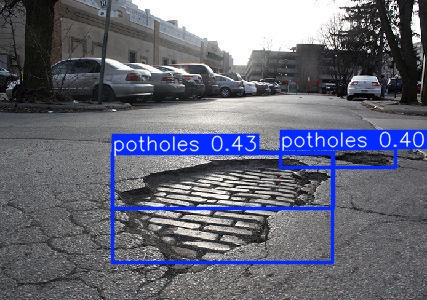

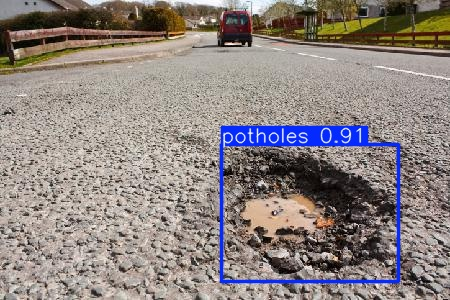

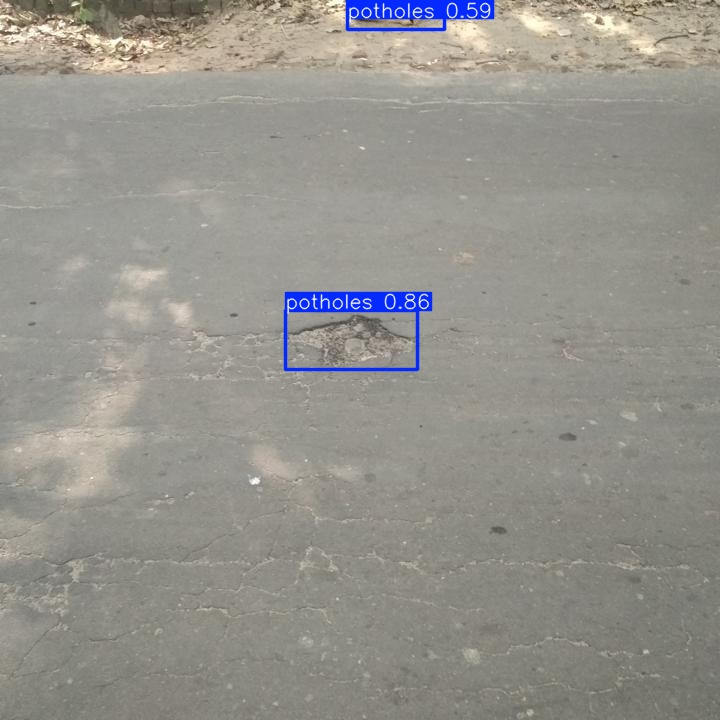

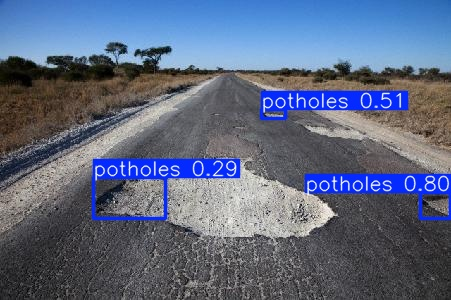

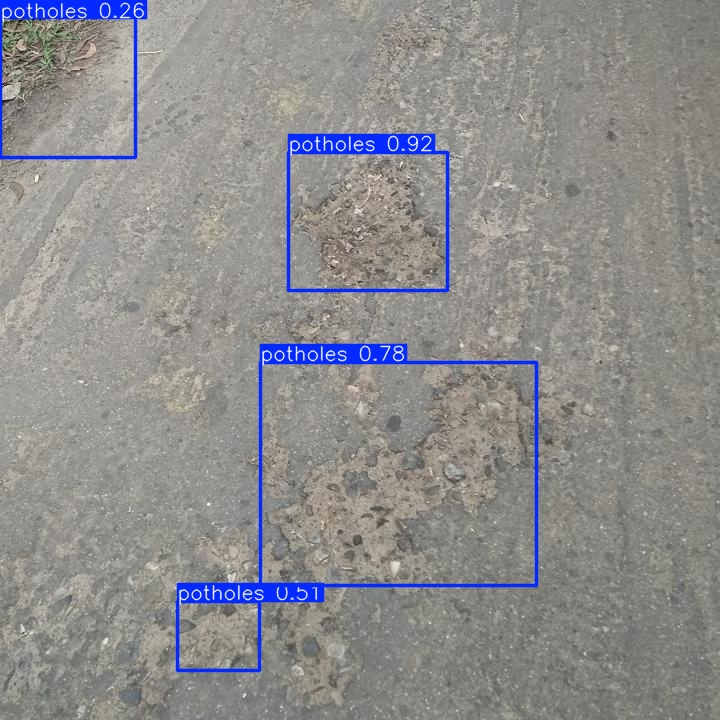

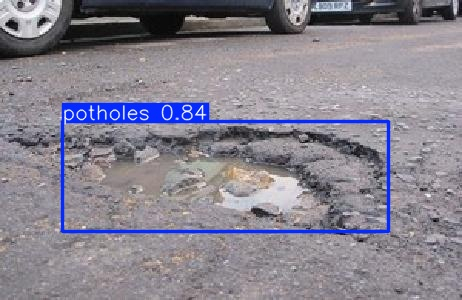

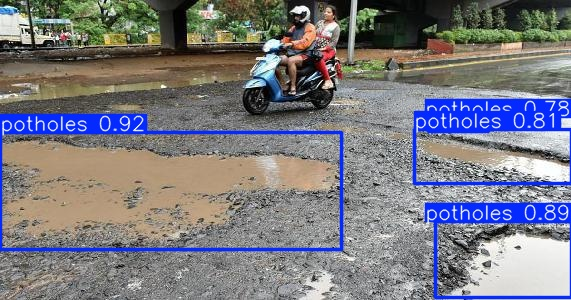

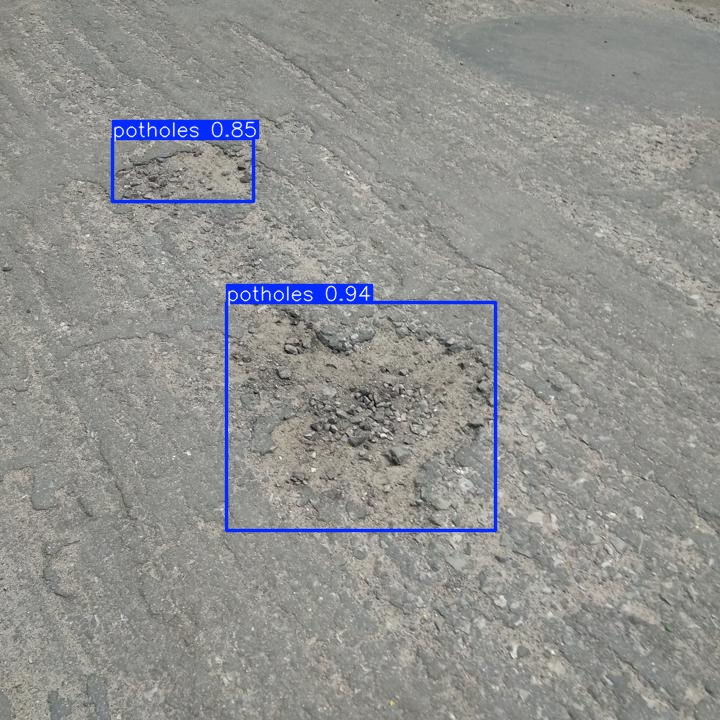

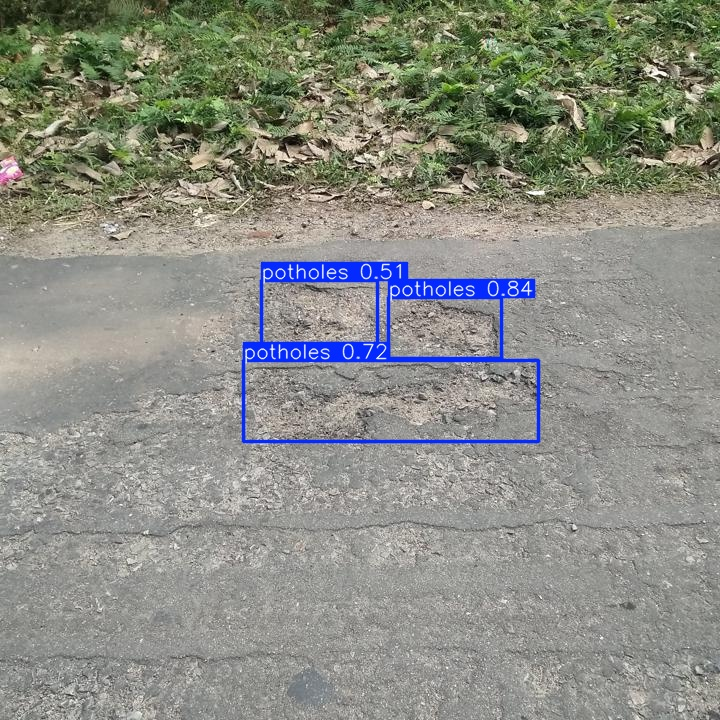

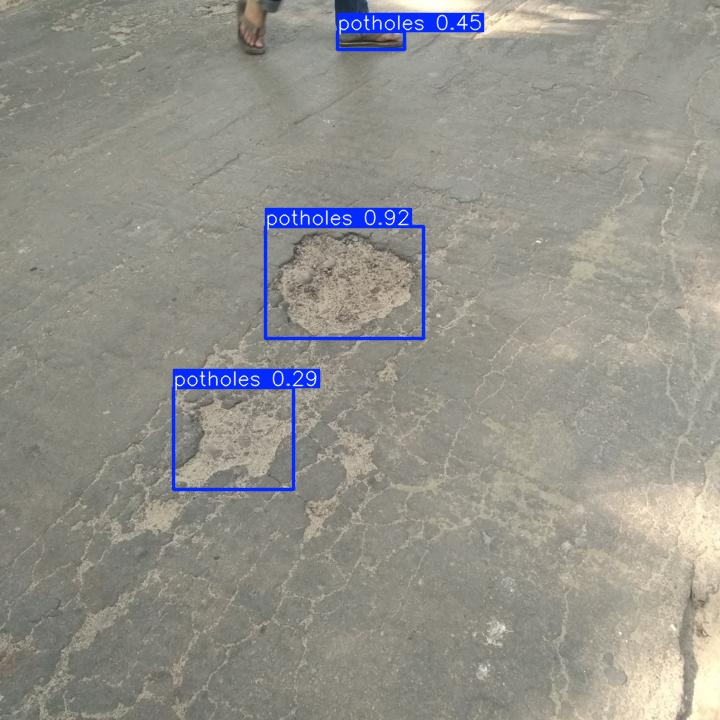

In [18]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]: # Display first 10 predicted images from the test set
  display(Image(filename=image_path, height=400))
  print('\n')

The model should draw a box around each object of interest in each image. If it isn't doing a good job of detecting objects, here are a few tips:

1. Double-check your dataset to make sure there are no labeling errors or conflicting examples.
2. Increase the number of epochs used for training.
3. Use a larger model size (e.g. `yolo11l.pt`).

You can also run the model on video files or other images images by uploading them to this notebook and using the above `!yolo detect predict` command, where `source` points to the location of the video file, image, or folder of images. The results will be saved in `runs/detect/predict`.

Drawing boxes on images is great, but it isn't very useful in itself. It's also not very helpful to just run this models inside a Colab notebook: it's easier if we can just run it on a local computer. Continue to the next section to see how to download your newly trained model and run it on a local device.

## 7.1 Download YOLO Model

First, zip and download the trained model by running the code blocks below.

The code creates a folder named `my_model`, moves the model weights into it, and renames them from `best.pt` to `my_model.pt`. It also adds the training results in case you want to reference them later. It then zips the folder as `my_model.zip`.

In [19]:
# Create "my_model" folder to store model weights and train results
!mkdir /content/my_model
!cp /content/runs/detect/train/weights/best.pt /content/my_model/my_model.pt
!cp -r /content/runs/detect/train /content/my_model

# Zip into "my_model.zip"
%cd my_model
!zip /content/my_model.zip my_model.pt
!zip -r /content/my_model.zip train
%cd /content

cp: cannot stat '/content/runs/detect/train/weights/best.pt': No such file or directory
/content/my_model
	zip warning: name not matched: my_model.pt

zip error: Nothing to do! (/content/my_model.zip)
  adding: train/ (stored 0%)
  adding: train/labels.jpg (deflated 32%)
  adding: train/train_batch0.jpg (deflated 3%)
  adding: train/train_batch1.jpg (deflated 2%)
  adding: train/args.yaml (deflated 53%)
  adding: train/train_batch2.jpg (deflated 2%)
  adding: train/weights/ (stored 0%)
/content


In [20]:
# This takes forever for some reason, you can also just download the model from the sidebar
from google.colab import files

files.download('/content/my_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 7.2.1 Deploy on PC (Windows, Linux, or macOS)

The easiest way to run Ultralytics models on a PC is using Anaconda. Anaconda sets up a virtual Python environment and allows you to easily install Ultralytics and PyTorch. It automatically installs CUDA and cuDNN, which allows you to speed up model inference with your NVIDIA GPU.

**1. Download and Install Anaconda**

Go to the Anaconda download page at https://anaconda.com/download, click the “skip registration” button, and then download the package for your OS. When it's finished downloading, run the installer and click through the installation steps. You can use the default options for installation.

**2. Set up virtual environment**

Once it's installed, run Anaconda Prompt from the Start Bar. (If you're on macOS or Linux, just open a command terminal).

Issue the following commands to create a new Python environment and activate it:

```
conda create --name yolo-env1 python=3.12 -y
conda activate yolo-env1
```

Install Ultralytics (which also installs import libraries like OpenCV-Python, Numpy, and PyTorch) by issuing the following command:

```
pip install ultralytics
```

If you have an NVIDIA GPU, you can install the GPU-enabled version of PyTorch by issuing the following command:

```
pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
```

**3. Extract downloaded model**
Take the `my_model.zip` file you downloaded in Step 7.1 and unzip it to a folder on your PC. In the Anaconda Prompt terminal, move into the unzipped folder using:

```
cd path/to/folder
```

**4. Download and run yolo_detect.py**

Download the `yolo_detect.py` script into the `my_model` folder using:

```
curl -o yolo_detect.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/yolo_detect.py
```

Alright! We're ready to run the script. To run inference with a yolov8s model on a USB camera at 1280x720 resolution, issue:

```
python yolo_detect.py --model my_model.pt --source usb0 --resolution 1280x720
```

A window will appear showing a live feed from your webcam with boxes drawn around detected objects in each frame.

You can also run the model on an video file, image, or folder of images.





# Task
Train, test, and compare YOLOv9, YOLOv11, and YOLOv8 models for object detection. This involves training each model, reviewing their evaluation metrics (mAP, precision, recall) from console output and `results.csv` files, testing them on a test set, and visually inspecting their predictions. Finally, provide a comprehensive summary comparing their performance.

## Train YOLOv9 Model

### Subtask:
Modify the training command in cell `8bbpob1gTPlo` to use `model=yolov9c.pt` (a common YOLOv9 variant) and set the output directory to `name=yolov9_train`. Then, execute the cell to train the YOLOv9 model.


### Modify and Run Training Command for YOLOv9

As instructed, go to cell `8bbpob1gTPlo` and modify the training command to use `model=yolov9c.pt` and set the output directory name to `yolov9_train`.

**Original command in cell `8bbpob1gTPlo`:**
```bash
!yolo detect train data=/content/data.yaml model=yolo26s.pt epochs=60 imgsz=640
```

**Modified command (replace the above with this):**
```bash
!yolo detect train data=/content/data.yaml model=yolov9c.pt epochs=60 imgsz=640 name=yolov9_train
```

After making the change, run cell `8bbpob1gTPlo` to start training the YOLOv9 model.

**Reasoning**:
To review the full training metrics, I will display the contents of the `results.csv` file generated during the training process.



In [21]:
print('--- Displaying contents of results.csv ---')
# The results.csv file contains detailed training metrics for each epoch.
# The path is derived from the output of the training cell which indicates 'save_dir=/content/runs/detect/train'
!cat /content/runs/detect/train2/results.csv

--- Displaying contents of results.csv ---
epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
1,20.4214,1.83657,3.31093,1.76841,0.01461,0.07018,0.00744,0.00268,2.18862,72.4632,2.28109,0.0004,0.0004,0.0004
2,42.175,1.70354,2.27282,1.64577,0.04388,0.3614,0.02996,0.01139,2.22197,61.5221,2.77074,0.000811882,0.000811882,0.000811882
3,65.1469,1.81801,2.15607,1.71976,0.00129,0.12632,0.00086,0.00026,3.84801,inf,72.2596,0.00121545,0.00121545,0.00121545
4,84.4758,1.87613,2.20783,1.80271,0.00515,0.00351,0.00259,0.00026,nan,nan,nan,0.0016107,0.0016107,0.0016107
5,104.275,1.86135,2.071,1.74334,0.00806,0.01404,0.00416,0.00071,nan,nan,nan,0.0019208,0.0019208,0.0019208
6,124.782,1.85424,1.96893,1.75006,0.0564,0.05263,0.02152,0.00988,2.9844,15.108,3.30574,0.001901,0.001901,0.001901
7,145.264,1.82587,1.91453,1.71696,0.12843,0.10175,0.03754,0.01563,3.1929,7.77358,3.